In [104]:
################################
# Description: N-Body gravitation simulation using RK4 or constant
# acceleration kinematics for integrator. Code
# needs to have gravitational potential energy and "force per mass"
# calculations added.
# 
# Base code Author: Kyle Slinker, kyle.slinker@ncssm.edu
# Date: Nov 18 2019
#
# Code changed for Project Author: Al Pagar
################################

# runtime is proportional to tmax * N**2 divided by dt
# n is number of objects


#bring in numerical functions and plotting utilities
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import matplotlib.animation as animation

#choose time step (years)
dtlist = [1,.5,.5,0.000002,0.000002]
#choose maximum time (years)

tmaxlist = [1000,250,100,.003,.004]
#choose objects to include in simulation
objects = []
objects.append(np.array(["Cassiopeiae_A", "Cassiopeiae_B"]))
objects.append(np.array(["Cassiopeiae_A", "Cassiopeiae_B","Quad_Cassiopeiae_A","Quad_Cassiopeiae_B"]))
objects.append(np.array(["Cassiopeiae_A", "Cassiopeiae_B","Quad_Cassiopeiae_A","Quad_Cassiopeiae_B", "Sext_Cassiopeiae_A", "Sext_Cassiopeiae_B"]))
objects.append(np.array(["M_b", "M_a"]))
objects.append(np.array(["M_b", "M_a","M_b_shifted", "M_a_shifted"]))


#simulation names
simulation_names = []
simulation_names.append("Archid System")
simulation_names.append("Quad Archid System")
simulation_names.append("Sextuple Archid System")
simulation_names.append("binary central star in the planetary nebula M 3-1 ")
simulation_names.append("binary central star but two running in there")


#physical data
#note: units used are solar masses, astronomical units, and years (for mass, length, and time, respectively)

#value for the gravitational constant ("big G")
newtong=4*np.pi*np.pi

#initialize initial data arrays with a test particle
masses={"Test":0}
initial_positions={"Test":np.array([0,0,0])}
initial_velocities={"Test":np.array([0,0,0])}

#achrid system

#Cassiopeiae A
masses["Cassiopeiae_A"]=.9 #Solar Masses
initial_positions["Cassiopeiae_A"]=np.array([35.5, 0.1, 0.2]) #AU
velocity = (2 * np.pi * 35.5)/480
initial_velocities["Cassiopeiae_A"]=np.array([velocity/100,velocity,velocity/100]) #AU/yr

masses["Cassiopeiae_B"]=.57 #Solar Masses
initial_positions["Cassiopeiae_B"]=np.array([-35.5, 0.2, 0.1]) #AU
velocity = -(2 * np.pi * 35.5)/480
initial_velocities["Cassiopeiae_B"]=np.array([velocity/100,velocity,velocity/100]) #AU/yr


#TWO achrid systems
#shifted right by 100 AU
masses["Quad_Cassiopeiae_A"]=.9 #Solar Masses
initial_positions["Quad_Cassiopeiae_A"]=np.array([100+35.5, 0.1, 0.2]) #AU
velocity = (2 * np.pi * 35.5)/480
initial_velocities["Quad_Cassiopeiae_A"]=np.array([velocity/100,velocity,velocity/100]) #AU/yr

masses["Quad_Cassiopeiae_B"]=.57 #Solar Masses
initial_positions["Quad_Cassiopeiae_B"]=np.array([100+35.5+35.5+35.5, 0.2, 0.1]) #AU
velocity = -(2 * np.pi * 35.5)/480
initial_velocities["Quad_Cassiopeiae_B"]=np.array([velocity/100,velocity,velocity/100]) #AU/yr


#THREE achrid systems
#shifted right by 50 AU and 100 AU up
masses["Sext_Cassiopeiae_A"]=.9 #Solar Masses
initial_positions["Sext_Cassiopeiae_A"]=np.array([50+35.5, 100, .1]) #AU
velocity = (2 * np.pi * 35.5)/480
initial_velocities["Sext_Cassiopeiae_A"]=np.array([velocity/100,velocity,velocity/100]) #AU/yr

masses["Sext_Cassiopeiae_B"]=.57 #Solar Masses
initial_positions["Sext_Cassiopeiae_B"]=np.array([50+35.5*3,100, 0.1]) #AU
velocity = -(2 * np.pi * 35.5)/480
initial_velocities["Sext_Cassiopeiae_B"]=np.array([velocity/100,velocity,velocity/100]) #AU/yr


#binary central star in the planetary nebula M 3-1 
#shifted in y direction 30
masses["M_a"]=0.65
T =0.00348211232877
#calculating the semi major axis
a1 = ((T**2*39.629*(.17 + .65))/(4*np.pi**2))**(1/3) 
initial_positions["M_a"]=np.array([a1/2, 30, 0])
new_v = 2*np.pi*a1/T
initial_velocities["M_a"]=np.array([0, new_v, 0])

masses["M_b"]=.17
#calculating the semi major
a1 = ((T**2*39.629*(.17+.65))/(4*np.pi**2))**(1/3)
initial_positions["M_b"]=np.array([-a1/2, 30, 0])
new_v = 2*np.pi*a1/T
initial_velocities["M_b"]=np.array([0, new_v/2, 0])

#shifted up a bit so they crash
masses["M_a_shifted"]=0.65
T =0.00348211232877
a1 = ((T**2*39.629*(.17 + .65))/(4*np.pi**2))**(1/3)
initial_positions["M_a_shifted"]=np.array([a1/2, 30.3, 0])
new_v = 2*np.pi*a1/T
initial_velocities["M_a_shifted"]=np.array([0, -new_v, 0])

masses["M_b_shifted"]=.17
a1 = ((T**2*39.629*(.17+.65))/(4*np.pi**2))**(1/3)
initial_positions["M_b_shifted"]=np.array([-a1/2, 30.3, 0])
new_v = 2*np.pi*a1/T
initial_velocities["M_b_shifted"]=np.array([0, -new_v/2, 0])




    
#description of function get_potential:
# - find the gravitational binding energy between object 1 and object 2;
#   return zero if the objects are the same object
#inputs:
# - positions of object 1 and object 2; p1 and p2; each a 3x1 numpy array
# - the masses of object 1 and object 2; m1 and m2; each a single number
# - Newton's gravitation constant; g; single number
#output:
# - gravitational potential energy between object 1 and object 2; single number

def get_potential(p1,p2,m1,m2,g):
    if np.array_equal(p1,p2):
        return 0.0
    else:
        #setting up radius vector 

        r = p1-p2
        rmag = np.linalg.norm(r) #normalizes the radius vector
                
        #define force object 2 exerts on object 1
        return ((-g * m1 * m2)/rmag) 
        

#description of function get_acceleration:
# - find the acceleration of object 1 caused by object 2;
#   return zero if the objects are the same object
#inputs:
# - positions of object 1 and object 2; p1 and p2; each a 3x1 numpy array
# - the mass of object 2; m2; single number
# - Newton's gravitation constant; g; single number
#output:
# - the acceleration of object 1; 3x1 numpy array

def get_acceleration(p1,p2,m2,g):
    if np.array_equal(p1,p2):
        return np.array([0,0,0])
    else:
        r = p1-p2
        rmag = np.linalg.norm(r) #normalizes the radius vector
        
        return -g* (m2/rmag**3) * (r)





#take a step using classic Runge-Kutta
#https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods 
#this specific function does the RK4 method which calculates the next step in the trajectories using a combination of 
# simpsons method and eulers method 
def fourth_order_step(x,v,m,nmax,newtong,saveq):
    k1=np.zeros((nmax,3))
    k2=np.zeros((nmax,3))
    k3=np.zeros((nmax,3))
    k4=np.zeros((nmax,3))
    l1=np.zeros((nmax,3))
    l2=np.zeros((nmax,3))
    l3=np.zeros((nmax,3))
    l4=np.zeros((nmax,3))
    
    a=np.zeros((nmax,3))
    # Calculate acceleration using Newton's law of gravitation
    for i in range(0,nmax):
        for j in range(0,nmax):
            a[i]+=get_acceleration(x[i,:,-1],x[j,:,-1],m[j],newtong)
    
    k1=dt*v[:,:,-1]
    l1=dt*a
    
    a=np.zeros((nmax,3))
    # Calculate acceleration at the midpoint
    for i in range(0,nmax):
        for j in range(0,nmax):
            a[i]+=get_acceleration(x[i,:,-1]+k1[i]/2.0,x[j,:,-1]+k1[j]/2.0,m[j],newtong)
        
    k2=dt*(v[:,:,-1]+l1/2.0)
    l2=dt*a
    
    a=np.zeros((nmax,3))
    # Calculate acceleration at the midpoint
    for i in range(0,nmax):
        for j in range(0,nmax):
            a[i]+=get_acceleration(x[i,:,-1]+k2[i]/2.0,x[j,:,-1]+k2[j]/2.0,m[j],newtong)
        
    k3=dt*(v[:,:,-1]+l2/2.0)
    l3=dt*a
    
    a=np.zeros((nmax,3))
    # Calculate acceleration at the endpoint
    for i in range(0,nmax):
        for j in range(0,nmax):
            a[i]+=get_acceleration(x[i,:,-1]+k3[i],x[j,:,-1]+k3[j],m[j],newtong)
        
    k4=dt*(v[:,:,-1]+l3)
    l4=dt*a
    
    if saveq:
        # Save the updated positions and velocities if saveq is True
        x=np.append(x,np.zeros((nmax,3,1)),axis=2)
        v=np.append(v,np.zeros((nmax,3,1)),axis=2)
        x[:,:,-1]=x[:,:,-2]+(k1+2.0*k2+2.0*k3+k4)/6.0
        v[:,:,-1]=v[:,:,-2]+(l1+2.0*l2+2.0*l3+l4)/6.0
    else:
        x[:,:,-1]+=(k1+2.0*k2+2.0*k3+k4)/6.0
        v[:,:,-1]+=(l1+2.0*l2+2.0*l3+l4)/6.0
        
    return x,v


#gather a few pieces of information based on choosen parameters
def simulate(objects):
    # Get the maximum number of objects
    nmax=objects.size
    # Initialize arrays for mass, position, and velocity
    m=np.zeros(nmax)
    x=np.zeros((nmax,3,1))
    v=np.zeros((nmax,3,1))
     # Gather information for each object based on the chosen parameters
    for i in range(0,nmax):
        m[i]=masses[objects[i]]
        x[i,:,0]=initial_positions[objects[i]]
        v[i,:,0]=initial_velocities[objects[i]]

    #evolve the system; this is the part where the simulation is actually carried out
    for t in range(0,(int)(tmax/dt)):
        x,v=fourth_order_step(x,v,m,nmax,newtong,t%10==0)

    return x,v,m

# Function that converts time in seconds to a formatted string
def time_convert(sec):
  # Convert seconds to minutes and seconds
  mins = sec // 60
  sec = sec % 60
  # Convert minutes to hours and minutes
  hours = mins // 60
  mins = mins % 60
  # Return the formatted string representing the runtime
  return "Runtime = {0}:{1}:{2}".format(int(hours),int(mins),sec)

#this function makes the plots
def make_plot(x,tmax,name,cm,cnames):
    f=plt.figure()
    # Set the aspect ratio of the plot to be equal
    plt.axes().set_aspect('equal','datalim')
    
    # Plot the trajectories
    for i in range(len(x)):
        plt.plot(x[i,0],x[i,1],label=cnames[i])
    # Set labels and title for the plot
    plt.xlabel("x (AU)")
    plt.ylabel("y (AU)")
    plt.title(f'{name} trajectories')
    # Display the legend in the upper right corner
    plt.legend(loc="upper right")
    plt.show()


    #-----------------------
    #3d Projections
    ax = plt.figure().add_subplot(projection='3d')

    # By using zdir='y', the y value of these points is fixed to the zs value 0
    # and the (x, y) points are plotted on the x and z axes.
    for i in range(len(x)):
            ax.plot(x[i][0],x[i][1],x[i][2],label=cnames[i])
    # Make legend, set axes limits and labels
    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Y (AU)')
    ax.set_zlabel('Z (AU)')

    # Customize the view angle so it's easier to see that the scatter points lie
    # on the plane y=0
    ax.view_init(elev=20., azim=-35)
    plt.title(f'{name} 3D trajectories')
    plt.legend(loc="upper right")
    plt.show()

    #--------------------------
    #Separations
    # This section calculates the distance from each point in x to the center of mass and creates a plot of the separation.
    for i in range(len(x)):
        # Create a new figure for each trajectory
        f=plt.figure()
        # Calculate the separation by finding the Euclidean distance between each point and the center of mass
        sep=np.sqrt(np.sum((x[i]-np.array(cm).T)**2,axis=0))
        # Create a plot of time versus separation
        plt.plot((tmax/sep.size)*np.array(range(0,sep.size)),sep)
        # Set labels and title for the plot
        plt.xlabel("Time (years)")
        plt.ylabel("Separation(AU)")
        plt.title(f"{cnames[i]} Separation from center of mass")
        # Show the plot
        plt.show()
    
    #----------------
    #Animation
    # Create a figure and axes object
    fig, ax = plt.subplots()
    line = []
    # Set equal aspect ratio for the plot
    plt.axis('equal')
    # Iterate over x and create line plots for each element
    for i in range(len(x)):
            line.append(ax.plot(x[i,0],x[i,1],label=cnames[i])[0])
    # Display legend in the upper right corner
    plt.legend(loc='upper right')
    plt.title(f'{name} trajectories')

    # Define the update function for the animation
    def update(frame):
        # for each frame, update the data stored on each artist.
        # update the line plot:
        for i in range(len(line)):
            line[i].set_xdata(x[i][0][:frame])
            line[i].set_ydata(x[i][1][:frame])
        return line
    # Create the animation using FuncAnimation
    ani = animation.FuncAnimation(fig=fig, func=update, frames=len(x[0][0]), interval =.01)
    # Save the animation as a GIF file using the Pillow writer
    ani.save(filename=f"{name}_trajectory.gif", writer="pillow")

#calculates center of mass
def center_m(x,m):
    newx = []
    # Convert each sublist in x to a NumPy array and transpose them
    for i in range(len(x)):
        arr = np.array(x[i]) 
        newx.append(arr.T)

    centerm_pos = []
    # Iterate over the elements of newx[0] (assuming it is not empty)
    # to calculate the center of mass positions
    for i in range(len(newx[0])):
        add = [m[j]*newx[j][i] for j in range(len(newx))]
        vec = np.array([0,0,0])
        # Calculate the weighted sum of each column
        for i in add:
            vec = vec + i
        # Calculate the center of mass position by dividing the sum by the total mass
        out = vec/np.sum(m)
        # Store the center of mass position in centerm_pos
        centerm_pos.append(out)
    # Return the list of center of mass positions
    return centerm_pos


Simulation: Archid System
Runtime = 0:0:0.6322948932647705
time step (years): 1 | Number of years lapsed: 1000 




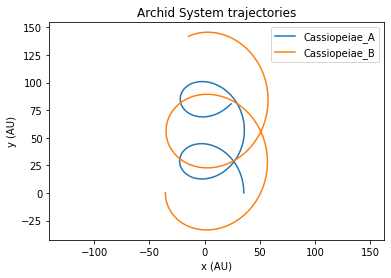

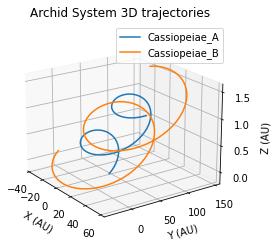

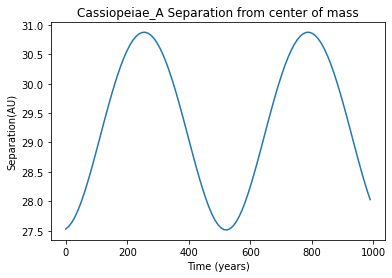

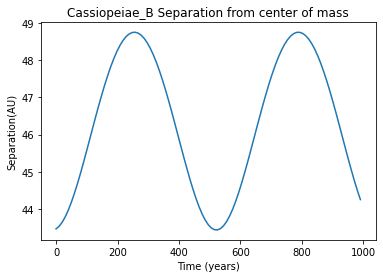

Simulation: Quad Archid System
Runtime = 0:0:0.988924503326416
time step (years): 0.5 | Number of years lapsed: 250 




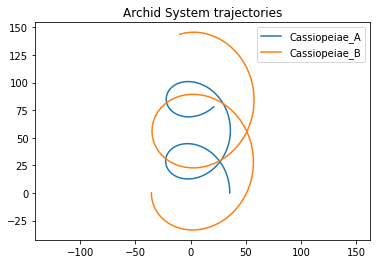

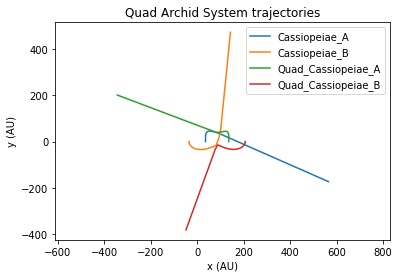

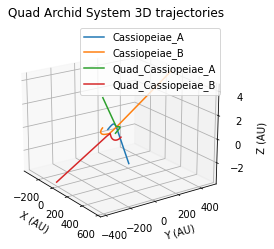

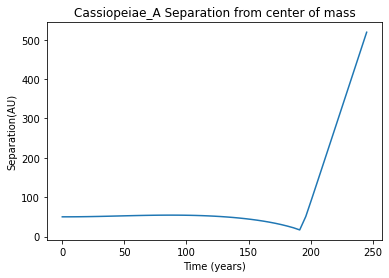

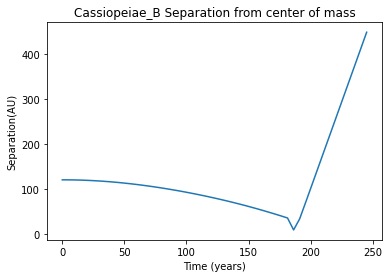

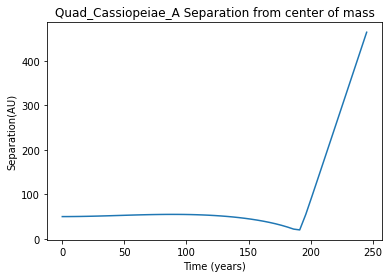

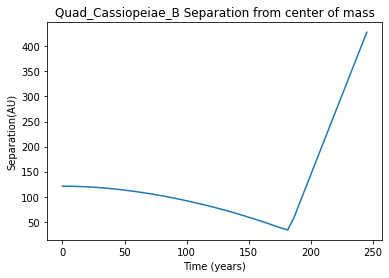

Simulation: Sextuple Archid System
Runtime = 0:0:1.0090289115905762
time step (years): 0.5 | Number of years lapsed: 100 




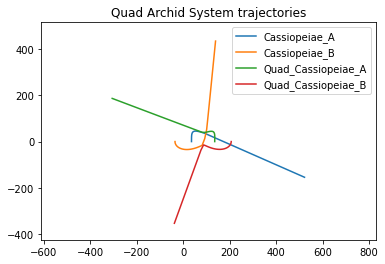

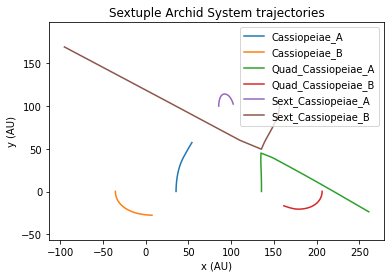

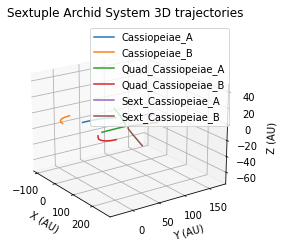

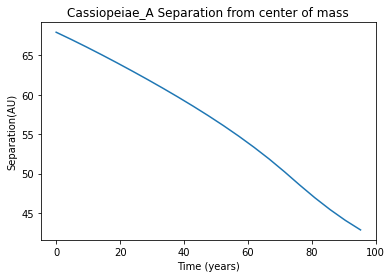

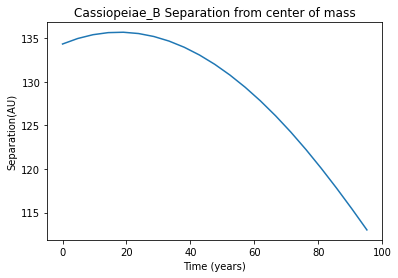

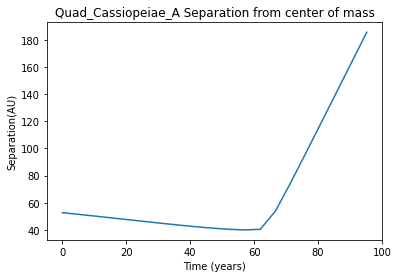

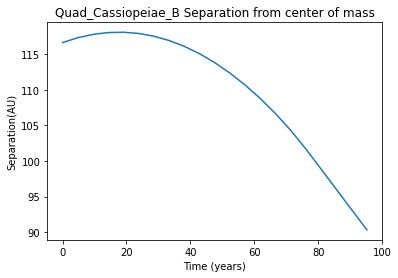

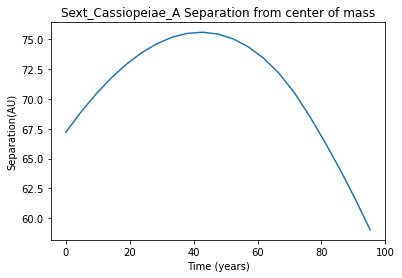

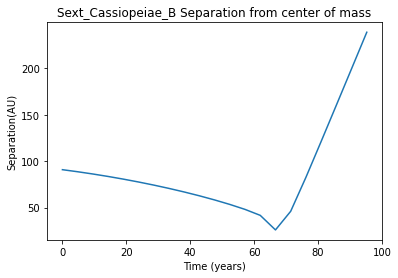

Simulation: binary central star in the planetary nebula M 3-1 
Runtime = 0:0:0.7535150051116943
time step (years): 2e-06 | Number of years lapsed: 0.003 




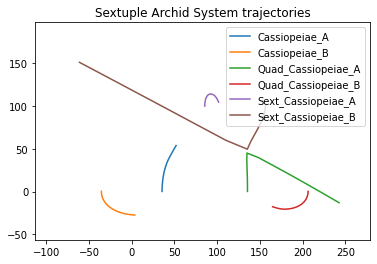

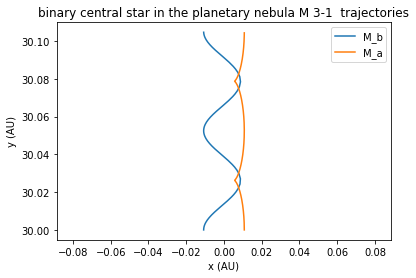

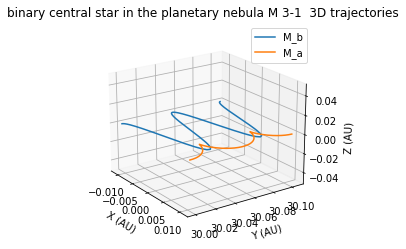

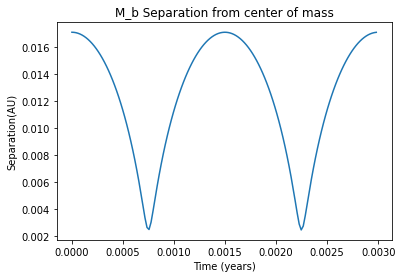

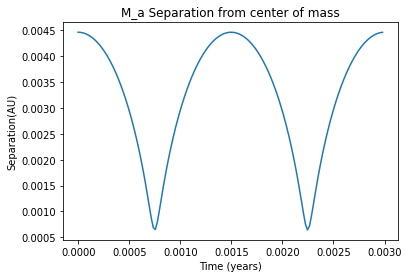

Simulation: binary central star but two running in there
Runtime = 0:0:4.214022159576416
time step (years): 2e-06 | Number of years lapsed: 0.004 




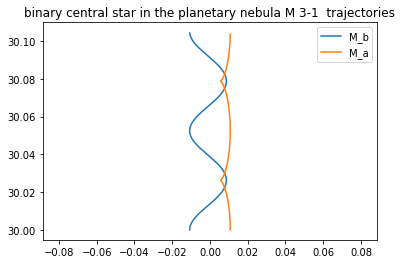

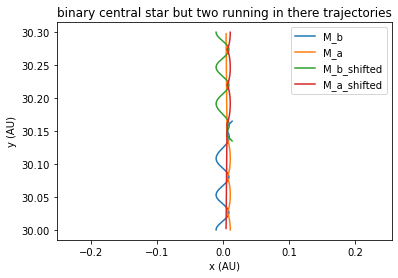

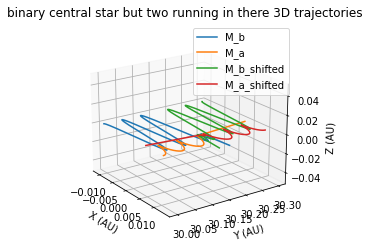

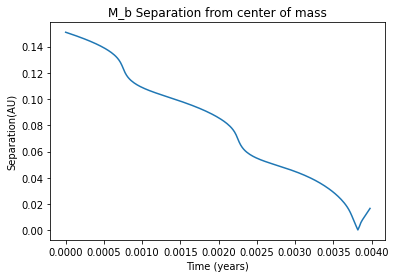

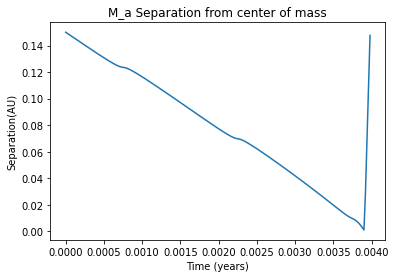

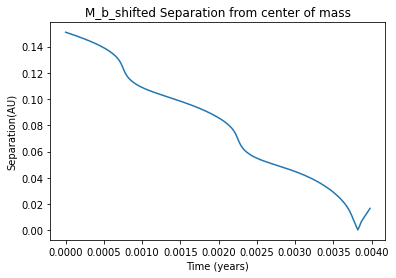

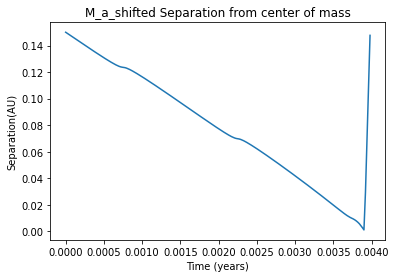

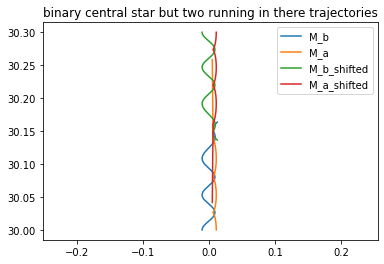

In [105]:
for p in range(len(objects)):
    #initiate all the initial parameters for the specific simulation
    dt = dtlist[p]
    tmax = tmaxlist[p]
    name = simulation_names[p]
    component_names = objects[p]
    dt2=dt*dt

    #starting the new simulation by printing the name of the simulations
    print(f'Simulation: {name}')

    #starts the timer to see how long the simulation is
    start_time = time.time()
    #simulate the object using the simulation function
    x,v,m = simulate(objects[p])
    #ends time
    end_time = time.time()
    #calculates time lapsed
    time_lapsed = end_time - start_time
    print(f'{time_convert(time_lapsed)}')
    print(f'time step (years): {dt} | Number of years lapsed: {tmax} ')
    print("\n")

    cm_pos = center_m(x,m)
    #runs the funciton that outputs all the plots
    make_plot(x,tmax,name,cm_pos, component_names)
